https://github.com/sflydatascience/homework1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx

pd.set_option('display.max_rows', 1000)

# Explore Online

#### Basic Data Quality Checks and Summary

In [2]:
online = pd.read_csv('data/online.csv')

In [3]:
online['dt'] = pd.to_datetime(online['dt'])

In [4]:
online.head()

,session,visitor,dt,custno,category,event1,event2
0,419542,140970,2016-09-16 05:03:23,3840,1,NaN,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1
2,2638740,419353,2017-05-24 16:10:38,21248,1,NaN,1
3,880408,90673,2017-10-28 13:42:38,39168,1,NaN,1
4,2612179,191542,2016-05-17 06:30:32,47616,1,NaN,1


In [5]:
online.isna().sum()

session          0
visitor          0
dt               0
custno           0
category         0
event1      789846
event2           0
dtype: int64

In [6]:
online.isna().sum()

session          0
visitor          0
dt               0
custno           0
category         0
event1      789846
event2           0
dtype: int64

#### Number of Sessions by Day of Week

In [7]:
online.head()

,session,visitor,dt,custno,category,event1,event2
0,419542,140970,2016-09-16 05:03:23,3840,1,NaN,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1
2,2638740,419353,2017-05-24 16:10:38,21248,1,NaN,1
3,880408,90673,2017-10-28 13:42:38,39168,1,NaN,1
4,2612179,191542,2016-05-17 06:30:32,47616,1,NaN,1


In [8]:
online['DOW'] = online['dt'].dt.dayofweek
unique_sessions = online[['DOW', 'session']].drop_duplicates()
sessions_by_dow = unique_sessions.groupby('DOW').count()

In [9]:
sessions_by_dow.index = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]

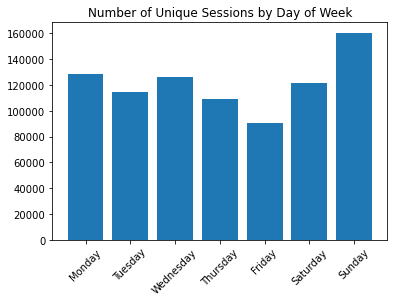

In [10]:
plt.title('Number of Unique Sessions by Day of Week')
plt.bar(sessions_by_dow.index, sessions_by_dow['session'])
plt.xticks(rotation=45)
plt.show()

#### Number of Sessions By Day

In [11]:
online['date'] = online['dt'].dt.date
unique_sessions = online[['date', 'session']].drop_duplicates()
sessions_per_day = unique_sessions.groupby('date').count()

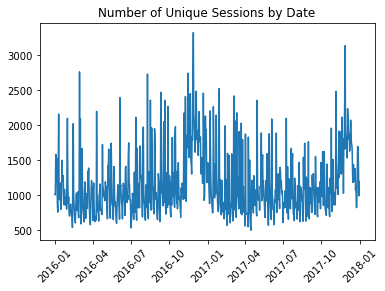

In [12]:
plt.plot(sessions_per_day)
plt.title('Number of Unique Sessions by Date')
plt.xticks(rotation=45)
plt.show()

#### Distince Customers

#### Evaluate Event 1

In [13]:
event_1_counts = online.groupby('event1').count()['session']

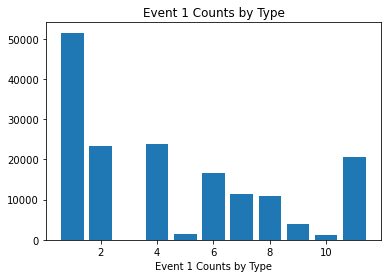

In [14]:
plt.bar(event_1_counts.index, event_1_counts)
plt.title('Event 1 Counts by Type')
plt.xlabel('Event 1 Counts by Type')
plt.show()

#### Evaluate Event 2

In [15]:
event_2_counts = online.groupby('event2').count()['session']

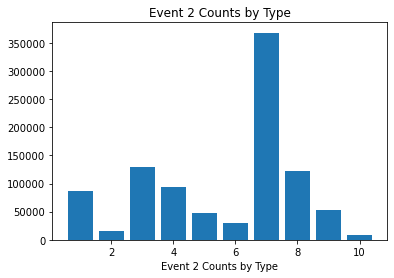

In [16]:
plt.bar(event_2_counts.index, event_2_counts)
plt.title('Event 2 Counts by Type')
plt.xlabel('Event 2 Counts by Type')
plt.show()

# Explore order.csv

In [17]:
order = pd.read_csv('data/order.csv')

In [18]:
order.head()

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
0,18944,64694,2016-11-27 20:57:20,NaN,1,53.30
1,18944,114405,2017-04-29 20:18:04,NaN,1,0.10
2,18944,28906,2017-04-23 21:31:03,NaN,1,141.66
3,36096,62681,2016-02-25 07:16:33,NaN,1,36.82
4,1,1,2017-06-12 08:27:59,NaN,1,8.35


#### Assumptions
    - Assuming that prodcat2 of 96 is always associated prodcat1 of 7
        - Assuming that the overlap of with prodcat1 is a data quality issue
        - Normally I would confirm this with a SME, but elected not to because of time

In [19]:
def clean_96_overlap(prd_cat1, prd_cat2):
    if prd_cat2 == 96:
        prd_cat1 = 7
    return prd_cat1

def test_clean_96_overlap():
    in_data = [
        [0,1],
        [3,96],
        [7,96]
    ]
    obs = [clean_96_overlap(x[0], x[1]) for x in in_data]
    exp = [0,7,7]
    assert obs == exp

test_clean_96_overlap()

In [20]:
def prod_cat2_nan_fill(prd_cat1, prd_cat2):
    if np.isnan(prd_cat2):
        return -1*prd_cat1
    else:
        return prd_cat2

def test_prod_cat2_nan_fill():
    in_data = [
        [1,np.nan],
        [2,np.nan],
        [3,199],
        [1,2]
    ]
    obs = [prod_cat2_nan_fill(x[0], x[1]) for x in in_data]
    exp = [-1,-2, 199, 2]
    assert obs == exp, f'obs:{obs}, exp:{exp}'

test_prod_cat2_nan_fill()

In [21]:
order['prodcat2'] = order[['prodcat1', 'prodcat2']].apply(
    lambda row: prod_cat2_nan_fill(row['prodcat1'], row['prodcat2']), axis=1
)

In [22]:
order['prodcat1'] = order[['prodcat1', 'prodcat2']].apply(
    lambda row: clean_96_overlap(row['prodcat1'], row['prodcat2']), axis=1
)

#### Clean Up Dates

In [23]:
order['orderdate'] = pd.to_datetime(order['orderdate'])
order['order_year_month'] = order['orderdate'].dt.to_period('M')
order['order_year_month'] = order['order_year_month'].apply(lambda dt: dt.to_timestamp())

In [24]:
order_clean = order.groupby(
    ['custno', 'ordno', 'orderdate', 'order_year_month', 'prodcat2', 'prodcat1'], as_index=False
).count()


In [25]:
order.head()

,custno,ordno,orderdate,prodcat2,prodcat1,revenue,order_year_month
0,18944,64694,2016-11-27 20:57:20,-1.0,1.0,53.30,2016-11-01
1,18944,114405,2017-04-29 20:18:04,-1.0,1.0,0.10,2017-04-01
2,18944,28906,2017-04-23 21:31:03,-1.0,1.0,141.66,2017-04-01
3,36096,62681,2016-02-25 07:16:33,-1.0,1.0,36.82,2016-02-01
4,1,1,2017-06-12 08:27:59,-1.0,1.0,8.35,2017-06-01


#### Check Primary Key

In [26]:
order.shape

(263278, 7)

In [27]:
order

,custno,ordno,orderdate,prodcat2,prodcat1,revenue,order_year_month
0,18944,64694,2016-11-27 20:57:20,-1.0,1.0,53.30,2016-11-01
1,18944,114405,2017-04-29 20:18:04,-1.0,1.0,0.10,2017-04-01
2,18944,28906,2017-04-23 21:31:03,-1.0,1.0,141.66,2017-04-01
3,36096,62681,2016-02-25 07:16:33,-1.0,1.0,36.82,2016-02-01
4,1,1,2017-06-12 08:27:59,-1.0,1.0,8.35,2017-06-01
...,...,...,...,...,...,...,...
263273,7443,99084,2018-09-23 16:02:08,253.0,1.0,6.67,2018-09-01
263274,6693,8660,2017-06-08 21:37:34,253.0,1.0,122.98,2017-06-01
263275,22914,36144,2017-05-12 14:07:18,253.0,1.0,143.34,2017-05-01
263276,36088,62664,2018-03-11 20:19:18,253.0,1.0,49.75,2018-03-01


In [28]:
order[['ordno','prodcat2', 'revenue']].drop_duplicates().shape

(263278, 3)

#### Distribution of Revenue by Category 

In [29]:
order.groupby('prodcat1').agg('describe')['revenue']

,count,mean,std,min,25%,50%,75%,max
prodcat1,,,,,,,,
1.0,48672.0,74.880807,43.219422,0.00,37.0700,75.120,112.00,150.0
2.0,88684.0,75.208527,43.299121,0.00,37.7600,75.255,112.62,150.0
3.0,44005.0,74.751113,43.193123,0.01,37.3400,74.620,112.00,150.0
4.0,46681.0,74.653734,43.349344,0.00,37.1400,74.550,112.11,150.0
5.0,11180.0,75.676608,43.065655,0.00,38.7975,75.685,112.90,150.0
7.0,24056.0,74.620874,43.418959,0.01,36.8400,74.165,112.22,150.0


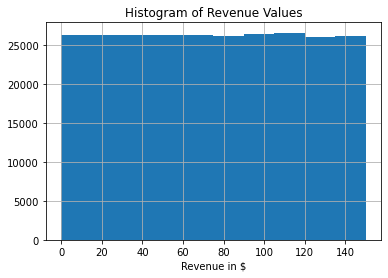

In [30]:
order['revenue'].hist()
plt.title('Histogram of Revenue Values')
plt.xlabel('Revenue in $')
plt.show()

#### Orders of Prodcat1 by date

In [31]:
orders_by_date_and_cat1_long = order.groupby(
    ['order_year_month', 'prodcat1'], as_index=False
).count()[
    ['order_year_month', 'prodcat1', 'ordno']
]

In [32]:
orders_by_date_and_cat1 = orders_by_date_and_cat1_long.pivot(
    index='order_year_month', columns='prodcat1', values='ordno'
)

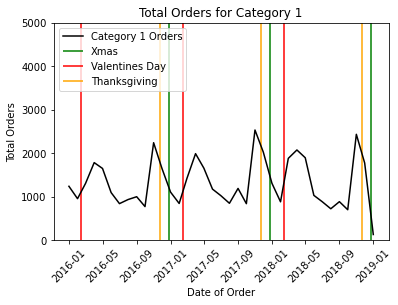

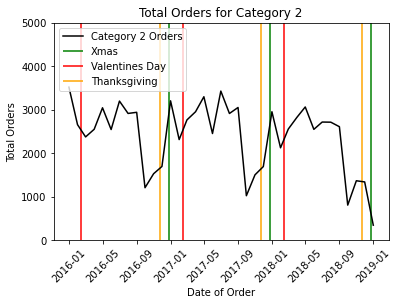

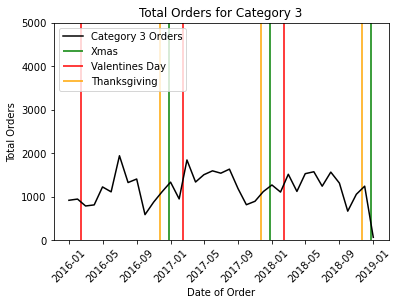

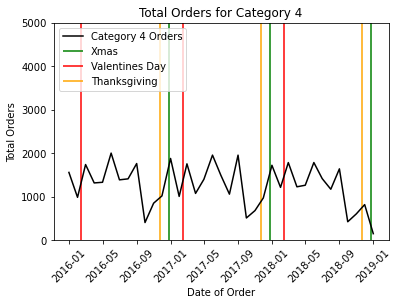

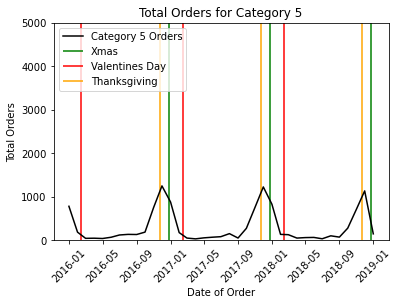

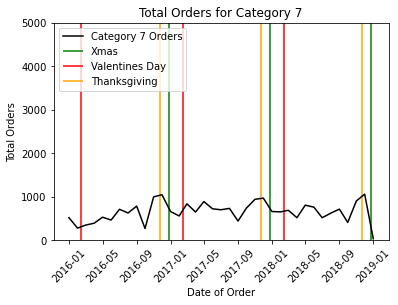

In [33]:
for i in [1,2,3,4,5,7]:
    plt.plot(
        orders_by_date_and_cat1.index, 
        orders_by_date_and_cat1[i], 
        label=f'Category {i} Orders',
        color='black'
    )
    plt.title(f'Total Orders for Category {i}')
    plt.xticks(rotation=45)
    plt.ylabel('Total Orders')
    plt.xlabel('Date of Order')
    plt.vlines([
        pd.to_datetime('12-25-2016'), pd.to_datetime('12-25-2017'), pd.to_datetime('12-25-2018')
    ],0,5000, colors='Green', label='Xmas')
    plt.vlines([
        pd.to_datetime('2-14-2016'), pd.to_datetime('2-14-2017'), pd.to_datetime('2-14-2018')
    ],0,5000, colors='red', label='Valentines Day')
    plt.vlines([
        pd.to_datetime('11-24-2016'), pd.to_datetime('11-23-2017'), pd.to_datetime('11-22-2018')
    ],0,5000, colors='Orange', label='Thanksgiving')
    plt.ylim(0,5000)
    plt.legend(loc='upper left')
    plt.show()

# Pair-wise Directed Graph of Items

## Get Edge Data

#### Get counts from each order

In [34]:
order['n'] = 1
prdcat2_orders = order[['ordno', 'prodcat2', 'n']].drop_duplicates()
purchases_by_order = prdcat2_orders.pivot('ordno', 'prodcat2','n').fillna(0)

#### Get Pairwise Association Rules
    - Would have created even more association rules with a lower min_support, but my Desktop ran out of RAM

In [59]:
itemsets = apriori(purchases_by_order, min_support=0.0008, use_colnames=True)
rules = association_rules(itemsets, metric="lift", min_threshold=.5)
rules['n_before_after'] = rules['antecedents'].apply(len) + rules['consequents'].apply(len)
one2one_rules = rules[rules['n_before_after'] == 2].copy()

#### Clean up Data

In [60]:
def clean_association_rules(raw_value):
    return list(raw_value)[0]

one2one_rules['antecedents'] = one2one_rules['antecedents'].apply(clean_association_rules).astype(int)
one2one_rules['consequents'] = one2one_rules['consequents'].apply(clean_association_rules).astype(int)

one2one_rules.sort_values('lift', ascending =False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,n_before_after
311,93,138,0.004976,0.001757,0.001363,0.273826,155.879593,0.001354,1.374660,2
310,138,93,0.001757,0.004976,0.001363,0.775665,155.879593,0.001354,4.435446,2
167,67,10,0.002572,0.003801,0.001229,0.477922,125.752302,0.001219,1.908143,2
166,10,67,0.003801,0.002572,0.001229,0.323374,125.752302,0.001219,1.474122,2
278,28,94,0.031934,0.001944,0.001830,0.057310,29.485598,0.001768,1.058732,2
279,94,28,0.001944,0.031934,0.001830,0.941581,29.485598,0.001768,16.571019,2
252,20,39,0.007220,0.015503,0.002485,0.344126,22.197968,0.002373,1.501046,2
253,39,20,0.015503,0.007220,0.002485,0.160276,22.197968,0.002373,1.182269,2
301,54,58,0.007274,0.017326,0.002418,0.332415,19.185885,0.002292,1.471983,2
300,58,54,0.017326,0.007274,0.002418,0.139553,19.185885,0.002292,1.153733,2


In [61]:
one2one_rules.shape

(314, 10)

## Get Node Data

In [62]:
order.head()

,custno,ordno,orderdate,prodcat2,prodcat1,revenue,order_year_month,n
0,18944,64694,2016-11-27 20:57:20,-1.0,1.0,53.30,2016-11-01,1
1,18944,114405,2017-04-29 20:18:04,-1.0,1.0,0.10,2017-04-01,1
2,18944,28906,2017-04-23 21:31:03,-1.0,1.0,141.66,2017-04-01,1
3,36096,62681,2016-02-25 07:16:33,-1.0,1.0,36.82,2016-02-01,1
4,1,1,2017-06-12 08:27:59,-1.0,1.0,8.35,2017-06-01,1


In [63]:
nodes = order.groupby(['prodcat2', 'prodcat1'], as_index=False).count()[['prodcat2','prodcat1','n']]
nodes['log_n_orders'] = np.log2(nodes['n'])

#### Set Node Colors

In [64]:
prdcat1_color = {
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'orange',
    5: 'navy',
    7: 'pink'
}

In [65]:
nodes['color'] = nodes['prodcat1'].apply(lambda row: prdcat1_color[row])

In [66]:
assert len(set(nodes['prodcat2'])) == len(nodes['prodcat2'])

#### Which Products Tend to be Purchased Together
- Load Edges
- Load Nodes
- Visualize

#### Filter Out Nodes with No Edges

In [77]:
connected_items = set(one2one_rules['antecedents']).union(set(one2one_rules['consequents']))

In [78]:
connected_nodes = nodes[nodes['prodcat2'].isin(connected_items)]

In [79]:
G = nx.from_pandas_edgelist(one2one_rules, 'antecedents', 'consequents', edge_attr ='confidence') 
G.add_nodes_from(connected_nodes['prodcat2'], size=nodes['log_n_orders'])

In [91]:
layouts = [
    'random_layout',
    'shell_layout',
    'fruchterman_reingold_layout',
    'spectral_layout',
    'kamada_kawai_layout',
    'spring_layout',
    'circular_layout'
]

random_layout


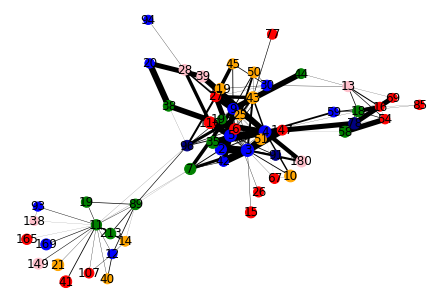

shell_layout


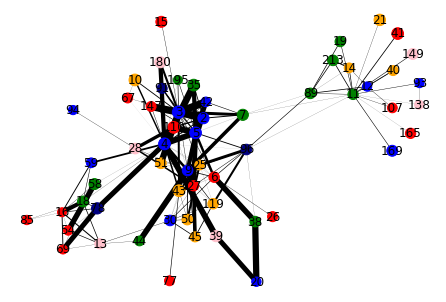

fruchterman_reingold_layout


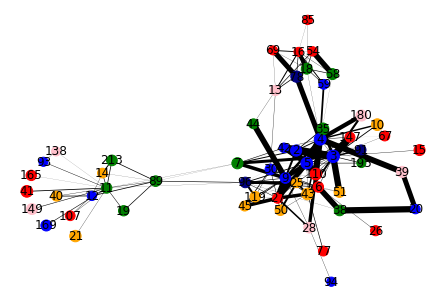

spectral_layout


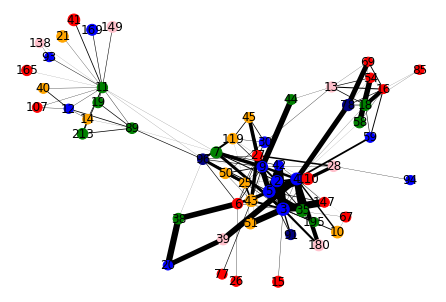

kamada_kawai_layout


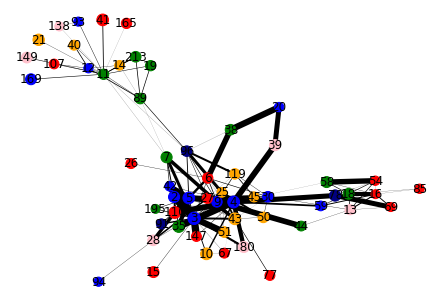

spring_layout


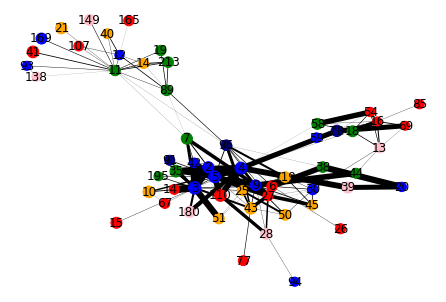

circular_layout


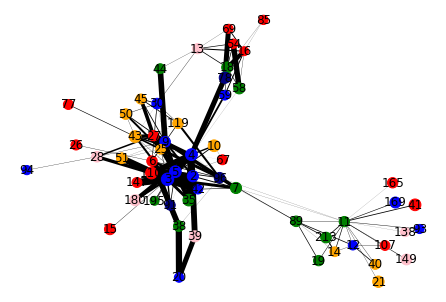

In [92]:
for layout in layouts:
    print(layout)
    pos = eval(f'nx.{layout}(G)')
    nx.draw(
        G, with_labels=True, 
        node_color = connected_nodes['color'],
        node_size = connected_nodes['log_n_orders']*10,
        width = one2one_rules['confidence']*10
    )

    plt.show()